# Dropsondes dataset JOANNE

The following script exemplifies the access and usage of dropsonde data measured 
during EUREC⁴A - ATOMIC.  

More information on the dataset can be found at https://github.com/Geet-George/JOANNE/tree/master/joanne/Level_3#level---3.
If you have questions or if you would like to use the data for a publication, please don't hesitate to get in contact with the dataset authors as stated in the dataset attributes `contact` and `author`.

## Get data
* To load the data we first load the EUREC⁴A meta data catalogue. More information on the catalog can be found [here](https://github.com/eurec4a/eurec4a-intake#eurec4a-intake-catalogue).

In [1]:
import datetime
import numpy as np
import eurec4a
cat = eurec4a.get_intake_catalog(use_ipfs="QmahMN2wgPauHYkkiTGoG2TpPBmj3p5FoYJAq9uE9iXT9N")

* We can funrther specify the platform, instrument, if applicable dataset level or variable name, and pass it on to dask.

```{note}
Have a look at the attributes of the xarray dataset `ds` for all relevant information on the dataset, such as author, contact, or citation infromation.
```

In [2]:
ds = cat.dropsondes.JOANNE.level3.to_dask()
ds

<xarray.Dataset>
Dimensions:            (sonde_id: 1068, alt: 1001, nv: 2)
Coordinates:
  * alt                (alt) int16 0 10 20 30 40 ... 9960 9970 9980 9990 10000
    interpolated_time  (sonde_id, alt) datetime64[ns] dask.array<chunksize=(267, 501), meta=np.ndarray>
    lat                (sonde_id, alt) float32 dask.array<chunksize=(267, 501), meta=np.ndarray>
    launch_time        (sonde_id) datetime64[ns] dask.array<chunksize=(1068,), meta=np.ndarray>
    lon                (sonde_id, alt) float32 dask.array<chunksize=(267, 501), meta=np.ndarray>
  * sonde_id           (sonde_id) object 'HALO-0119_s02' ... 'P3-0211_s43'
Dimensions without coordinates: nv
Data variables: (12/23)
    N_gps              (sonde_id, alt) float32 dask.array<chunksize=(267, 501), meta=np.ndarray>
    N_p                (sonde_id, alt) float32 dask.array<chunksize=(267, 501), meta=np.ndarray>
    N_rh               (sonde_id, alt) float32 dask.array<chunksize=(267, 501), meta=np.ndarray>
    N_ta               (sonde_id, alt) float32 dask.array<chunksize=(267, 501), meta=np.ndarray>
    alt_bnds           (alt, nv) int32 dask.array<chunksize=(1001, 2), meta=np.ndarray>
    flight_altitude    (sonde_id) float32 dask.array<chunksize=(1068,), meta=np.ndarray>
    ...                 ...
    ta                 (sonde_id, alt) float32 dask.array<chunksize=(267, 501), meta=np.ndarray>
    theta              (sonde_id, alt) float32 dask.array<chunksize=(267, 501), meta=np.ndarray>
    u                  (sonde_id, alt) float32 dask.array<chunksize=(267, 501), meta=np.ndarray>
    v                  (sonde_id, alt) float32 dask.array<chunksize=(267, 501), meta=np.ndarray>
    wdir               (sonde_id, alt) float32 dask.array<chunksize=(267, 501), meta=np.ndarray>
    wspd               (sonde_id, alt) float32 dask.array<chunksize=(267, 501), meta=np.ndarray>
Attributes: (12/16)
    ASPEN_version:           BatchAspen v3.4.3
    AVAPS_software_version:  Version 4.1.2
    Conventions:             CF-1.8
    JOANNE_version:          2.0.0
    author:                  Geet George
    author_email:            geet.george@mpimet.mpg.de
    ...                      ...
    featureType:             trajectory
    instrument_id:           Vaisala RD-41
    product_id:              Level-3
    project_id:              JOANNE
    reference:               George et al., JOANNE : Joint dropsonde Observat...
    title:                   EUREC4A JOANNE Level-3

## Load HALO flight phase information
All HALO flights were split up into flight phases or segments to allow for a precise selection in time and space of a circle or calibration pattern. For more information have a look at the respective [github repository](https://github.com/eurec4a/flight-phase-separation#segmentation-of-flights-during-eurec4a).

In [3]:
meta = eurec4a.get_flight_segments()

In [4]:
segments = [{**s,
             "platform_id": platform_id,
             "flight_id": flight_id
            }
            for platform_id, flights in meta.items()
            for flight_id, flight in flights.items()
            for s in flight["segments"]
           ]

In [5]:
segments_by_segment_id = {s["segment_id"]: s for s in segments}

In [6]:
segments_ordered_by_start_time = list(sorted(segments, key=lambda s: s["start"]))

We select all `dropsondes` with the quality flag `GOOD` from the first circle on February 5.

In [7]:
first_circle_Feb05 = [s["segment_id"]
                 for s in segments_ordered_by_start_time
                 if "circle" in s["kinds"]
                 and s["start"].date() == datetime.date(2020,2,5)
                 and s["platform_id"] == "HALO"
                ][0]
first_circle_Feb05

'HALO-0205_c1'

In [8]:
dropsonde_ids = segments_by_segment_id[first_circle_Feb05]["dropsondes"]["GOOD"]
dropsonde_ids

['HALO-0205_s01',
 'HALO-0205_s02',
 'HALO-0205_s03',
 'HALO-0205_s04',
 'HALO-0205_s05',
 'HALO-0205_s06',
 'HALO-0205_s07',
 'HALO-0205_s08',
 'HALO-0205_s09',
 'HALO-0205_s10',
 'HALO-0205_s12']

We transfer the information from our flight segment selection to the dropsondes data in the xarray dataset.

In [9]:
from functools import reduce
mask_sondes_first_circle_Feb05 = reduce(lambda a, b: a | b, [ds.sonde_id==d
                                                             for d in dropsonde_ids])
ds_sondes_first_circle_Feb05 = ds.isel(sonde_id=mask_sondes_first_circle_Feb05)

## Plots
You can get a list of available variables in the dataset from `ds.variables.keys()`  

```{note}
fetching the data and displaying it might take a few seconds
```

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("./mplstyle/book")

### Temperature and relative humidity as stored in the xarray dataset

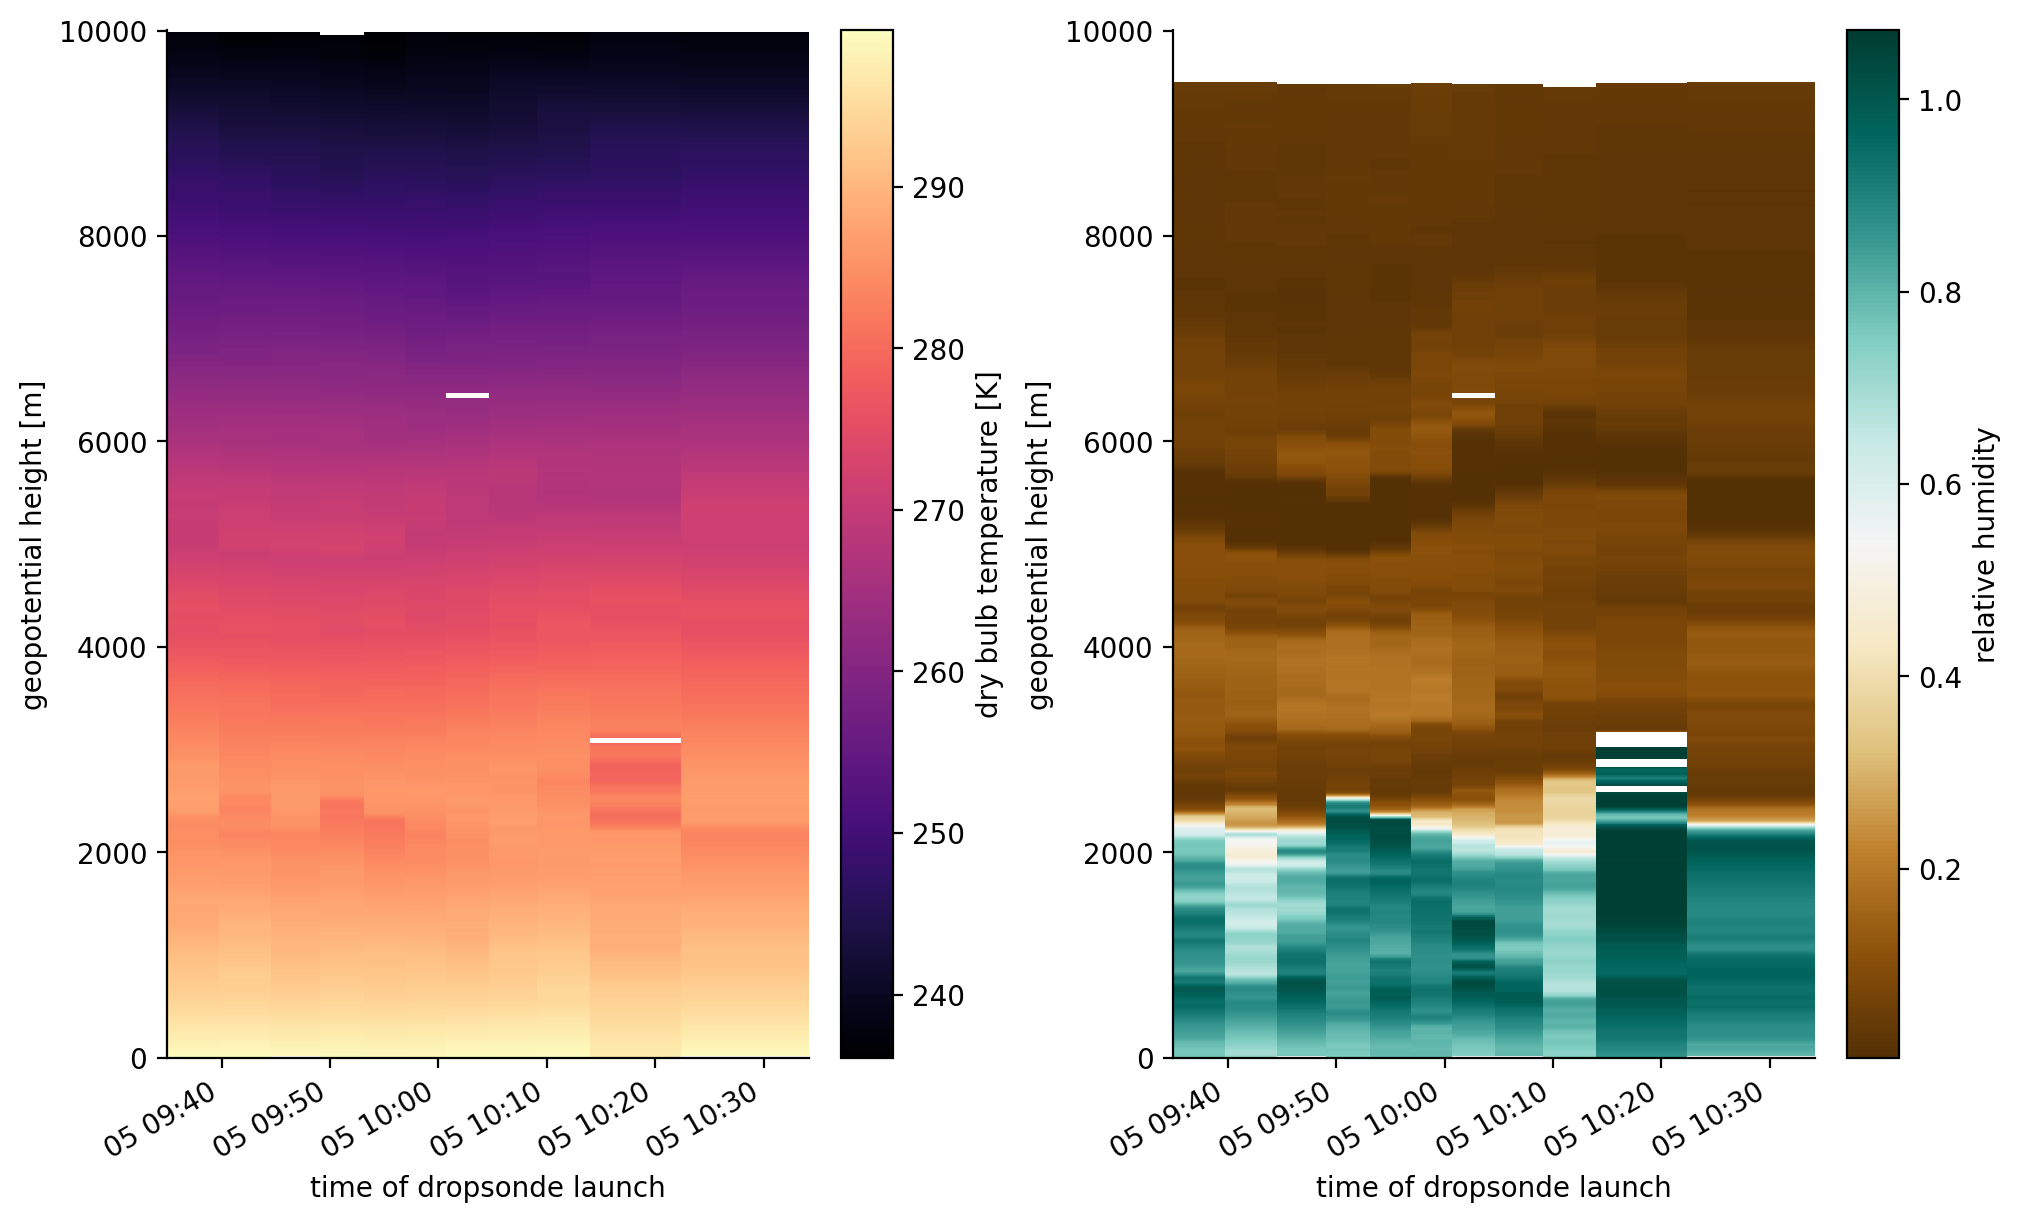

In [11]:
fig, (ax0, ax1) = plt.subplots(1, 2)
ds_sondes_first_circle_Feb05.ta.plot(ax=ax0, cmap="magma", x="launch_time", y="alt")
ds_sondes_first_circle_Feb05.rh.plot(ax=ax1, cmap="BrBG", x="launch_time", y="alt")
None

### Temperature and relative humidity profiles.
The temperature and humidity profiles are colored according to their launch time.

In [12]:
def dt64_to_dt(dt64):
    epoch = np.datetime64('1970-01-01T00:00:00')
    second = np.timedelta64(1, 's')
    return datetime.datetime.utcfromtimestamp(int((dt64 - epoch) / second))

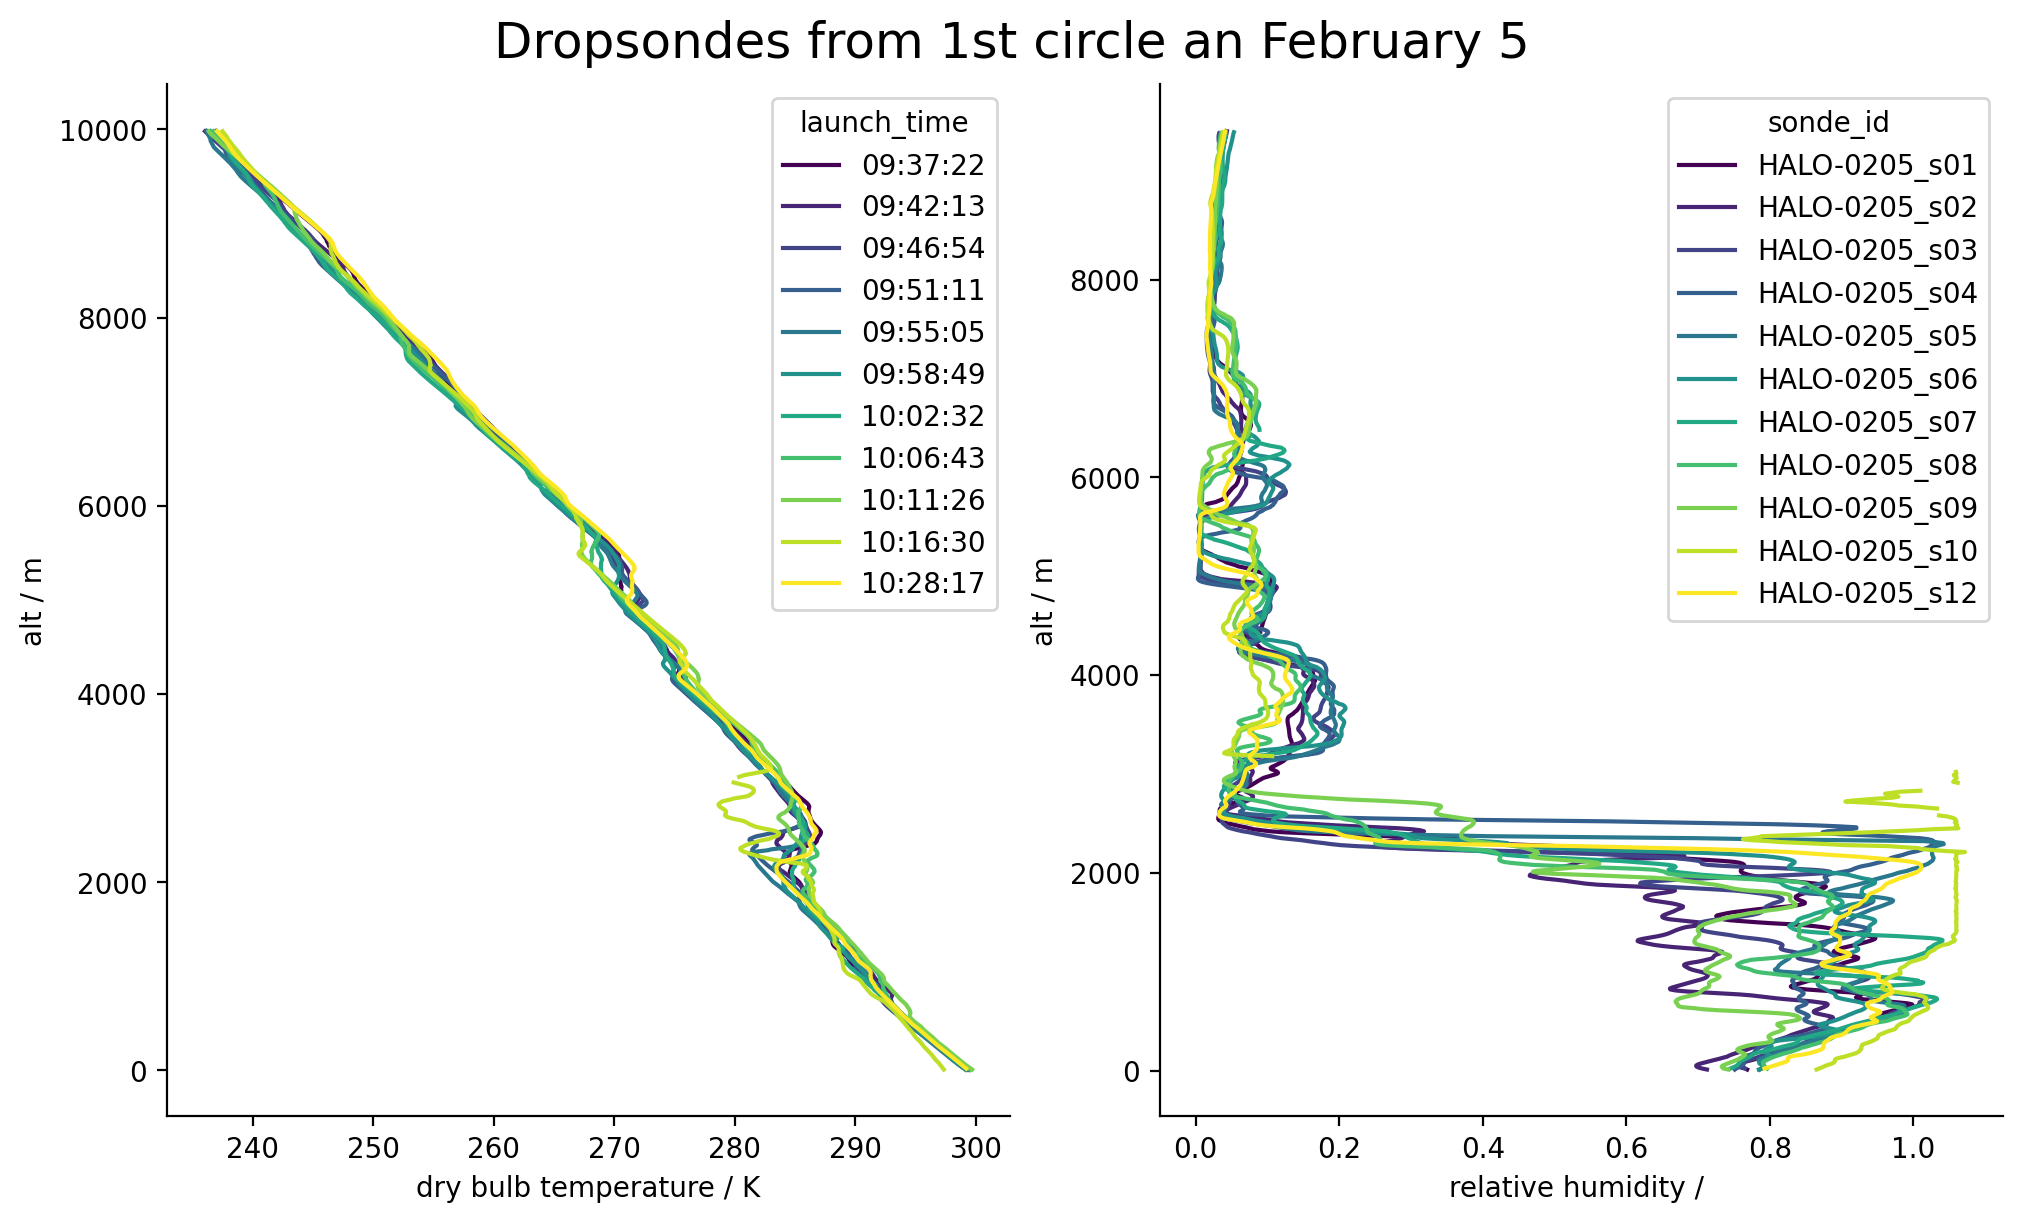

In [13]:
fig, (ax0, ax1) = plt.subplots(1, 2)

y = ds_sondes_first_circle_Feb05.alt

x0 = ds_sondes_first_circle_Feb05.ta.transpose("alt", "sonde_id")
ax0.set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, len(dropsonde_ids))))
ax0.plot(x0, y.data[:, np.newaxis])
ax0.set_xlabel(f"{x0.long_name} / {x0.units}")
ax0.set_ylabel(f"{y.name} / m")
ax0.legend([dt64_to_dt(d).strftime("%H:%M:%S")
            for d in ds_sondes_first_circle_Feb05.launch_time],
           title=x0.launch_time.name)

x1 = ds_sondes_first_circle_Feb05.rh.transpose("alt", "sonde_id")
ax1.set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, len(dropsonde_ids))))
ax1.plot(x1, y.data[:, np.newaxis])
ax1.set_xlabel(f"{x1.long_name} / {x1.units}")
ax1.set_ylabel(f"{y.name} / m")
ax1.legend(ds_sondes_first_circle_Feb05.sonde_id.values,
           title="sonde_id")

fig.suptitle('Dropsondes from 1st circle an February 5', fontsize=18)
None

### wind speed variations on HALO circles throughout February 5

To have a look at the wind speed variations during the circles flown by HALO,
we again select the relevant soundings:

In [14]:
mask_sondes_Feb05 = (ds.launch_time.astype("<M8[D]") == np.datetime64("2020-02-05")) & (ds.platform_id == "HALO")
ds_sondes_Feb05 = ds.isel(sonde_id=mask_sondes_Feb05)

We now want to show a time-altitude plot of the soundings. In order to show larger gaps between consecutive soundings,
we first resample the data onto an equidistant grid (along `launch_time` in stead of `sound_id`) using nearest-neighbor
interpolation, but limit the maximum difference between sonde launch and interpolated time to 5 minutes. That way,
smaller gaps in the plot are filled while larger gaps are indicated as missing values.

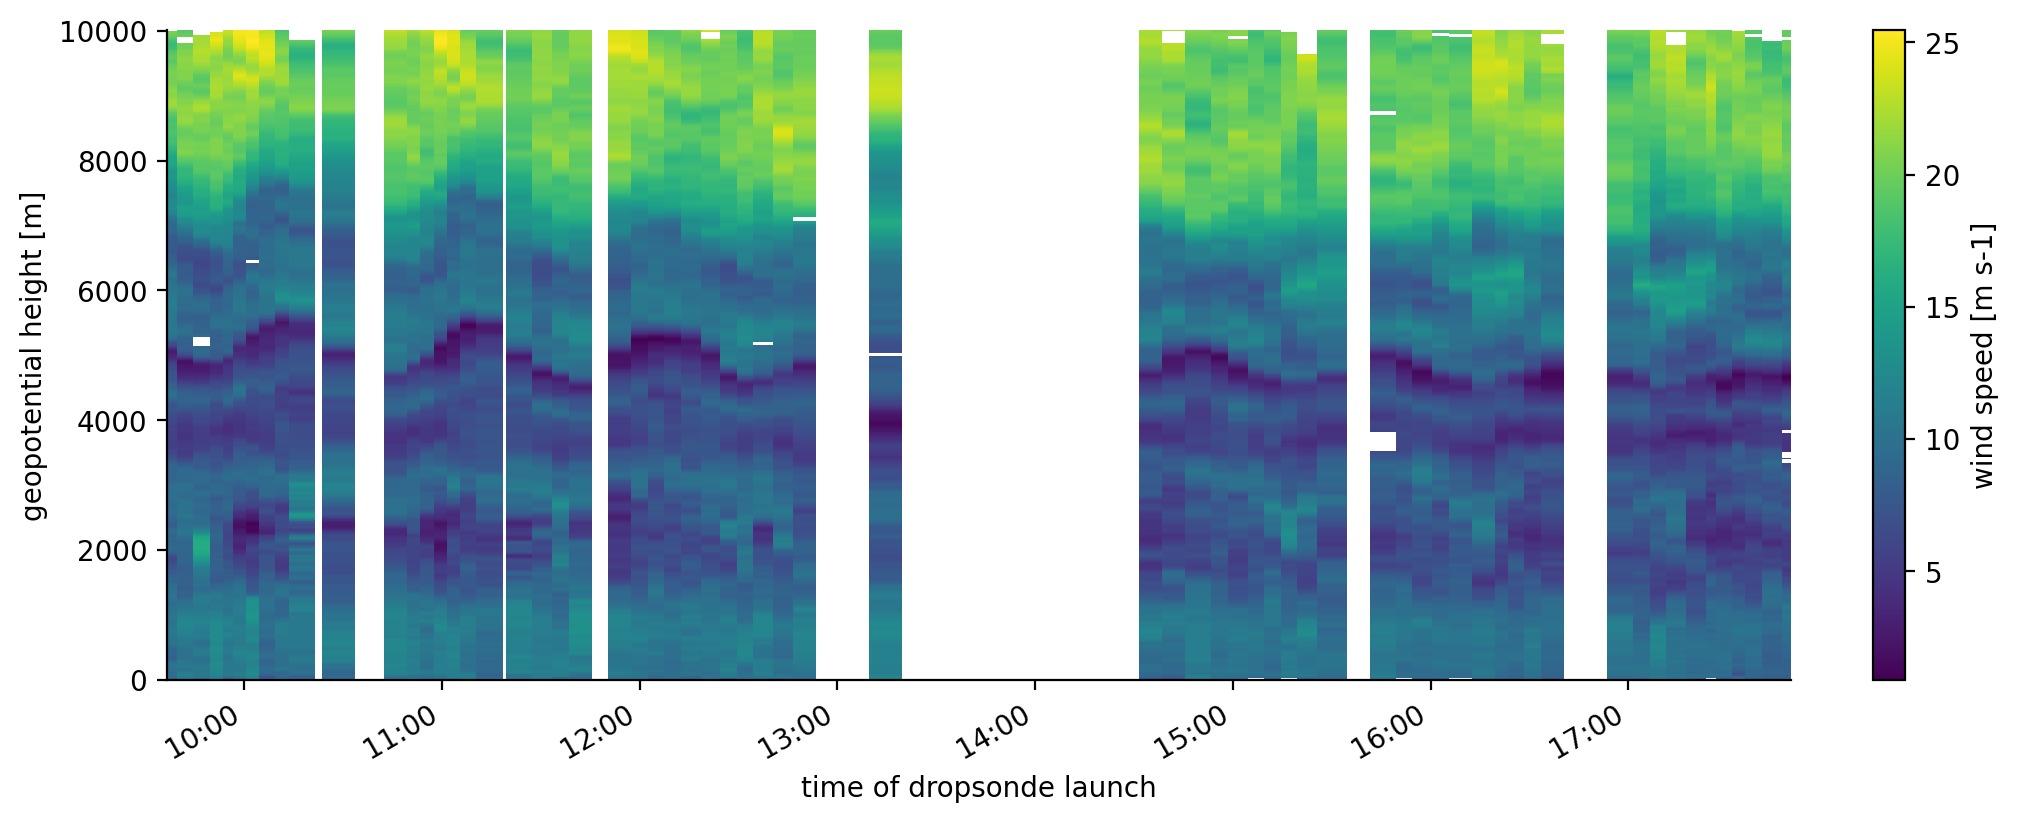

In [15]:
import matplotlib.dates as mdates
with plt.style.context("mplstyle/wide"):
    fig, ax = plt.subplots()
    ds_sondes_Feb05.wspd.load() \
                   .swap_dims({"sonde_id": "launch_time"}) \
                   .resample(launch_time="1min").nearest(np.timedelta64(5, "m")) \
                   .plot(ax=ax, x="launch_time", y="alt")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    None